## Author: Sahith Kumar Bandari
##Class: DS440

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip "/content/drive/MyDrive/Images.zip" -d "/content/data"

In [ ]:
!pip install whatimage
!pip install pyheif

In [3]:
!cp "/content/drive/MyDrive/img_dataset2" -r "/content"

## Data set handling

In [ ]:
import whatimage
import pyheif
from PIL import Image
import os

# decode the heic file format and convert into jpg image format
def decodeImage(bytesIo, output_folder , output_filename):
    with open(bytesIo, 'rb') as f:
      data = f.read()
      fmt = whatimage.identify_image(data)
      if fmt in ['heic', 'avif']:
        i = pyheif.read_heif(data)
        # decode the image
        pi = Image.frombytes(mode=i.mode, size=i.size, data=i.data)
        # save image to target folder based on the label
        pi.save( os.path.join( output_folder , output_filename+".jpg" ), format="jpeg")

In [ ]:
# dataset file list for violation
violation = ["/content/data/Images/10ft/10ft" ,
              "/content/data/Images/20ft/20ft" ,
              "/content/data/Images/30ft/30ft" ,
              "/content/data/Images/5ft/5ft"]

# dataset file list for non violation
not_violation = ["/content/data/Images/GT30FT/GT30FT"]

In [ ]:
# convert the all the files inside a folder into jpg format
def manage_dataset( input_folder , output_folder ):
  for i_file in os.listdir( input_folder ):
    out_filename = i_file.split(".")[0]
    i_filepath = os.path.join( input_folder , i_file )
    decodeImage( i_filepath , output_folder , out_filename )

In [ ]:
# create the violation dataset
for i_violation in violation :
  out_dir = "/content/img_dataset/violation"
  manage_dataset( i_violation , out_dir )

# create the non violation dataset
for i_nonviolation in not_violation :
  out_dir = "/content/img_dataset/non_violation"
  manage_dataset( i_nonviolation , out_dir )

## *data set loading from transformed jpg images*

In [ ]:
!cp "/content/drive/MyDrive/img_dataset" -r "/content"

## Import nessasary libraries

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten , Dropout , Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate
from keras.layers import Input
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
#sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix , classification_report

### visulaize image samples

In [5]:
def show_image_samples(gen):
    class_dict=gen.class_indices
    class_names=list( class_dict.keys())      # get the names of classes
    images,labels=next(gen) # get a sample batch from the generator   
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1) # add images to subplots
        image=(images[i]+1 )/2 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(image )
        index=labels[i]
        class_name= class_names[ int(index) ]
        class_name = " ".join( class_name )
        plt.title(class_name, color='blue', fontsize=16)  # show the class type as the title
        plt.axis('off')
    plt.show()

### define a dataframe for train and validation set

In [6]:
# dictionary with violation and non_violation details
data_dict = { "non_violation" : "/content/img_dataset2/non_violation" , 
              "violation" : "/content/img_dataset2/violation" }
data_set =[]
# define the data frame with each image path with it's target labels
for i_key , i_val in data_dict.items() :
  for i_file in os.listdir( i_val ):
    i_sample ={
        "img_path":os.path.join( i_val , i_file ) ,
        "target":i_key
    }
    data_set.append( i_sample )
# create the dataframe using pandas
df = pd.DataFrame( data_set )

In [7]:
df.head()

,img_path,target
0,/content/img_dataset2/non_violation/IMG_8264 c...,non_violation
1,/content/img_dataset2/non_violation/IMG_8323 c...,non_violation
2,/content/img_dataset2/non_violation/IMG_8345 c...,non_violation
3,/content/img_dataset2/non_violation/IMG_8327 c...,non_violation
4,/content/img_dataset2/non_violation/IMG_8294.jpg,non_violation


In [8]:
for i_info in [ "violation", "non_violation" ]:
  n_samples = len( df.query("target == @i_info")  )
  print("Samples in {} : {}".format( i_info , n_samples ))

Samples in violation : 692
Samples in non_violation : 540


In [9]:
# get the file count need to use
file_count = 540
samples = []
# iterate over every category type
for category in df['target'].unique():
    # get the data slice specific into a category
    category_slice = df.query("target == @category")    
    samples.append(category_slice.sample(file_count, replace=False,random_state=1))

# generate the new balanced dataframe
df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print (  df['target'].value_counts()) # check to see each class has 200 samples

non_violation    540
violation        540
Name: target, dtype: int64


In [10]:
df.to_csv( "filanames.csv" )

### load images from directory

In [11]:
# train validation data split
train_split=.9

train_df, valid_df=train_test_split( df , train_size=train_split, shuffle=True, random_state=123)

# define the image height and width
height=256
width=256
channels=3
# batch size for model training
batch_size=16
img_shape=(height, width, channels)
img_size=(height, width)

# define supporive function for image rescaling
def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1

# define training image data generator with data augmentation
train_gen=ImageDataGenerator(preprocessing_function=scalar , 
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)

# define testing image data generation with only image normalization
valid_gen=ImageDataGenerator(preprocessing_function=scalar)

# get the train dataset
train_data=train_gen.flow_from_dataframe( train_df, x_col='img_path', y_col='target', target_size=img_size, class_mode='binary',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
# get the validation dataset
valid_data=valid_gen.flow_from_dataframe( valid_df, x_col='img_path', y_col='target', target_size=img_size, class_mode='binary',
                                    color_mode='rgb', shuffle=, batch_size=batch_size)


train_steps=int(len(train_data.labels)/batch_size)
valid_steps = int( len(valid_df)/batch_size )

Found 971 validated image filenames belonging to 2 classes.
Found 108 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [12]:
# class dictionarty from data generators
class_dict=train_data.class_indices
print(class_dict)

{'non_violation': 0, 'violation': 1}


## visualize samples from train_dataset

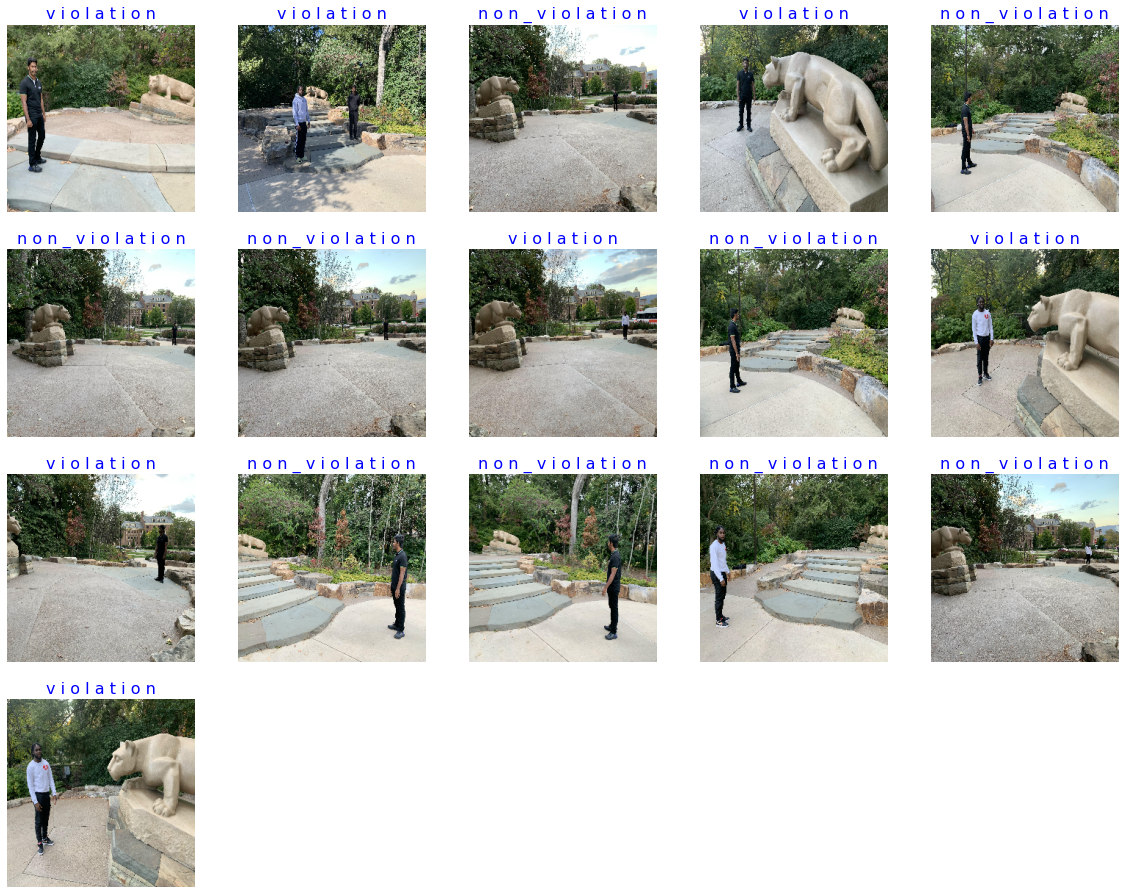

In [13]:
show_image_samples(valid_data)

## Model definition

In [14]:
def cnn(): 
    # using the pretrained model vgg16 since the dataset is not much  large
    VGG = tf.keras.applications.VGG16(  weights='imagenet', include_top=False)
    for layer in VGG.layers[:-5]:
      layer.trainable = False
    for layer in VGG.layers[-5:]:
      layer.trainable = True
    
    input_tensor = Input(shape=(256, 256 , 3))
    # define the base feature extraction model
    x = VGG( input_tensor , training=False )
    # add globalaverage pooling
    x = GlobalAveragePooling2D()(x)
    # normalization layer
    x = BatchNormalization()(x)
    # dropout for prevent overfitting
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    # dropout for prevent overfitting
    x = Dropout(0.5)(x)

    # multi output
    output = Dense( 1 , activation="sigmoid")(x)
 

    # model
    model = Model(input_tensor ,output)
    # define adam optimizer
    optimizer = tf.keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.1)
    # model compile with binary_crossentropy and metrics as accuracy
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [15]:
from tensorflow.keras.callbacks import LearningRateScheduler
import math

model = cnn()
model.summary()
initial_learning_rate = 0.001
# define a lr rate decay
def lr_step_decay(epoch, lr):
    drop_rate = 0.8
    epochs_drop = 3.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

# save the best model when validation  loss decrease
checkpoint = ModelCheckpoint('model_vgg16.h5', verbose=1, save_best_only=True)
callbacks=[LearningRateScheduler(lr_step_decay, verbose=1) , checkpoint]

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


## Model Training

In [17]:
# train the model using train and validation dataset
history = model.fit_generator( train_data ,
                epochs=6,
                verbose=1,
                callbacks= callbacks ,
                validation_data=valid_data  )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  



Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/6
61/61 [==============================] - ETA: 0s - loss: 0.0234 - accuracy: 0.9938
Epoch 00001: val_loss improved from 0.05247 to 0.02584, saving model to model_vgg16.h5
61/61 [==============================] - 210s 3s/step - loss: 0.0234 - accuracy: 0.9938 - val_loss: 0.0258 - val_accuracy: 1.0000 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/6
61/61 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 0.9969
Epoch 00002: val_loss improved from 0.02584 to 0.01312, saving model to model_vgg16.h5
61/61 [==============================] - 209s 3s/step - loss: 0.0142 - accuracy: 0.9969 - val_loss: 0.0131 - val_accuracy: 1.0000 - lr: 0.0010

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/6
61/61 [==============================] - ETA: 0s - loss: 0.0092 - accuracy: 0.9979
Epoch 00003: val_loss improved from 0.01312 to 0.00853, s

## plot model performance

In [18]:
def tr_plot(tr_data, start_epoch):
    #  get the train and validation loss , accuracy from history object
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]

    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)  

    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    # get the maximum  accuracy from the validation accuracy object
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    # indentify the best result epoch 
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    # plot training and validation loss
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')  # plot title
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    # plot training and validation accuracy results
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

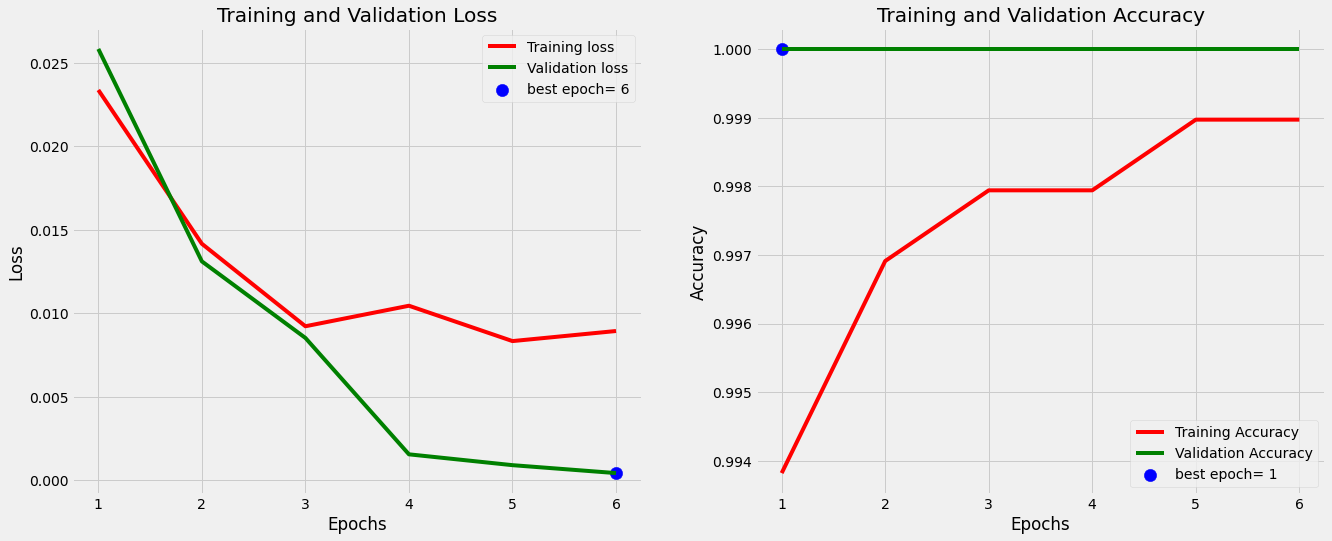

6/6 [==============================] - 17s 3s/step - loss: 4.4856e-04 - accuracy: 1.0000


In [19]:
tr_plot(history, 0)
acc=model.evaluate( valid_data ,batch_size=32, steps=valid_steps, verbose=1)[1]*100

## Model Classification Report

In [20]:
def print_info( test_gen, preds  ):
    # get the class label dictaionary from the dataset
    class_dict=test_gen.class_indices
    # target label names
    labels= test_gen.labels
    file_names= test_gen.filenames 

    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}

    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
 
    for i, p in enumerate(preds):
        # get the predicted binary classification label 0 or 1
        pred_index=np.round(p)        
        # append results to a list
        y_pred.append(pred_index)    
  
    if len(classes)<= 30:
        # create a confusion matrix and a test report        
        y_true= np.array(labels)        
        y_pred=np.array(y_pred)
        # get the confusion matrix for the results        
        cm = confusion_matrix(y_true, y_pred )
        # classification results stats on validation set
        clr = classification_report(y_true, y_pred, target_names=classes)
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        # plot results
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()    
        print("Classification Report:\n----------------------\n", clr)

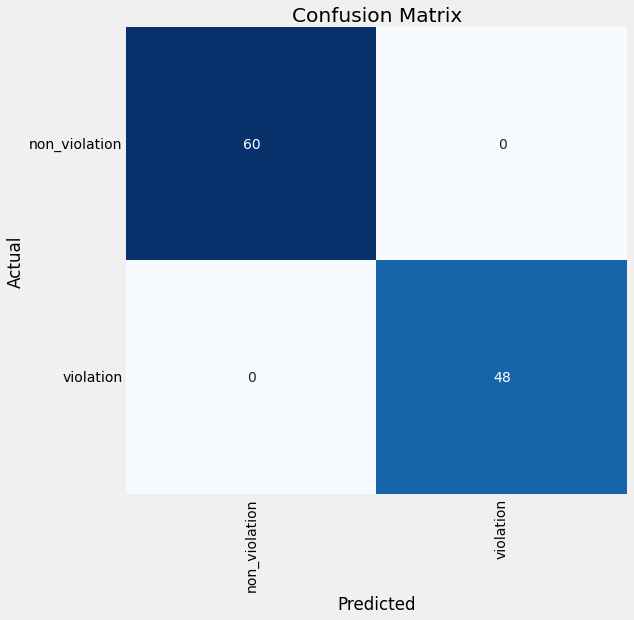

Classification Report:
----------------------
                precision    recall  f1-score   support

non_violation       1.00      1.00      1.00        60
    violation       1.00      1.00      1.00        48

     accuracy                           1.00       108
    macro avg       1.00      1.00      1.00       108
 weighted avg       1.00      1.00      1.00       108



In [21]:
print_code=0
preds=model.predict(valid_data) 
print_info( valid_data, preds)  

## predict on custom inputs

In [22]:
from keras.models import load_model
import keras
import numpy as np
from keras.preprocessing import image
keras.backend.clear_session()
# get the class dictionary from train dataset
class_dict=train_data.class_indices
# load the trained model
model_trained = load_model('/content/model_vgg16.h5')

In [23]:
import  cv2

# define dictionary with class name and index
idx2class = { idx : key for key , idx in class_dict.items() }

# predict the label for image
def predict_label( image ):
    # resize the image to (256,256)
    image = cv2.resize( image , (256,256))
    # normalize the image
    image = image/127.5 -1.0
    image = image.reshape(1, 256,256,3)
    # predict the label using the image
    model_pred = model.predict( image )
    i_idx = np.round( model_pred[0] )
    # the the index
    nonzero_idx = [int(i_idx[0])]
    pred_classes = []
    # get the predicted classes names
    for i_pred in nonzero_idx :
      pred_classes.append( idx2class[ i_pred ] )

    return pred_classes

In [24]:
# read the image
img_path = "/content/img_dataset2/violation/IMG_6944.jpg"
# convert the image to rgb
img_rgb = cv2.cvtColor(  cv2.imread( img_path ) , cv2.COLOR_BGR2RGB )
# predict the target label for the image input
model_prediction  = predict_label( img_rgb )
print("Model prediction on Image ", model_prediction)

Model prediction on Image  ['violation']
